## Sentiment Analysis of Stock Market using BERT

##### I will be using a data set of [Earnings Reports](https://github.com/areegtarek/Sentiment-Analysis-of-Earnings-Call-Transcripts-using-FinBert/tree/main) rather than historical prices. This makes it more difficult to Train the model, but that's okay because I'll be using a pre-trained NN which is pretty much what BERT is, which is a pre-trained NN that can be leveraSged through transferS learning. I will be using this to build a starting predictor value and then I will fine-tune it some more for better results. 

In [1]:
# Last updated: 10/26/2023.
# Copyright 2023 Shane Khalid. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

import itertools
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import osz
import pandas as pd
import pickle
import random
import re
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, DistilBertConfig, DistilBertForSequenceClassification, DistilBertTokenizer
from transformers import get_linear_schedule_with_warmup
import time
from datetime import datetime

In [2]:
df1= pd.read_csv('stock_price.csv')
df2= pd.read_csv('full_sample.csv')

In [3]:
df = df1.merge(df2, left_on='transcript', right_on='matches')
df

,Unnamed: 0_x,transcript_x,Positive,Negative,Neutral,Unnamed: 0_y,date,exchange,q,ticker,transcript_y,matches
0,0,'\nI would now like to hand the conference ove...,0.383404,0.022440,0.594157,6197,"Jul 23, 2021, 10:00 a.m. ET",NYSE: RNR,2021-Q2,RNR,Prepared Remarks:\nOperator\nGood day and than...,'\nI would now like to hand the conference ove...
1,1,"""\nToday, the company issued a press release a...",0.926385,0.010794,0.062821,1728,"May 10, 2021, 5:00 p.m. ET",NYSE: MODG,2021-Q1,MODG,Prepared Remarks:\nOperator\nGood day and than...,"""\nToday, the company issued a press release a..."
2,2,"""\nLamar has identified important factors that...",0.948464,0.014921,0.036615,792,"Aug 03, 2022, 8:00 a.m. ET",NASDAQ: LAMR,2022-Q2,LAMR,"Prepared Remarks:\nOperator\nExcuse me, everyo...","""\nLamar has identified important factors that..."
3,3,'\nLet me begin by giving you an overview of s...,0.422008,0.011877,0.566115,8775,"Apr 15, 2021, 10:00 a.m. ET",NASDAQ: CVAC,2020-Q4,CVAC,Prepared Remarks:\nSarah Fakih\nThank you. Goo...,'\nLet me begin by giving you an overview of s...
4,4,"""\nOperator\nLadies and gentlemen, thank you f...",0.169387,0.769734,0.060879,5789,"Oct 28, 2020, 8:30 a.m. ET",NYSE: ACCO,2020-Q3,ACCO,Prepared Remarks:\nOperator\nLadies and gentle...,"""\nOperator\nLadies and gentlemen, thank you f..."
...,...,...,...,...,...,...,...,...,...,...,...,...
183,183,"""\nLet me remind you, our statements today reg...",0.312985,0.511401,0.175614,516,"Dec 22, 2020, 9:00 a.m. ET",NYSE: KMX,2021-Q3,KMX,Prepared Remarks:\nOperator\nGood morning. My ...,"""\nLet me remind you, our statements today reg..."
184,184,"'\nNow, I will turn the call over to Cindy.', ...",0.923802,0.019065,0.057133,15395,"Aug 6, 2021, 9:00 a.m. ET",NYSE: BKD,2021-Q2,BKD,Prepared Remarks:\nKathy MacDonald -- Senior V...,"'\nNow, I will turn the call over to Cindy.', ..."
185,185,"'\nWith that balance sheet strength, we have t...",0.075664,0.878581,0.045755,17562,"Mar 01, 2022, 5:00 p.m. ET",NASDAQ: BGFV,2021-Q4,BGFV,"Prepared Remarks:\nOperator\nGood day, ladies ...","'\nWith that balance sheet strength, we have t..."
186,186,"'\nOperator\nLadies and gentlemen, thank you f...",0.024856,0.915266,0.059878,10278,"Feb 10, 2021, 5:00 p.m. ET",NASDAQ: SSNC,2020-Q4,SSNC,Prepared Remarks:\nOperator\nLadies and gentle...,"'\nOperator\nLadies and gentlemen, thank you f..."


#### Clean and Preprocess Data

In [4]:
# Print 60 random samples from the 'date' column
random_samples = df['date'].sample(n=60)
random_samples

115      Jul 29, 2021, 10:00 a.m. ET
26        Oct 28, 2021, 9:00 a.m. ET
53        Aug 5, 2020, 10:00 a.m. ET
95        Jul 31, 2019, 8:30 a.m. ET
12       Mar 24, 2021, 10:00 a.m. ET
20         Aug 7, 2019, 8:30 a.m. ET
6        Nov 08, 2022, 10:00 a.m. ET
36        Nov 30, 2021, 9:00 a.m. ET
4         Oct 28, 2020, 8:30 a.m. ET
99        Nov 09, 2022, 5:00 p.m. ET
133        Nov 4, 2020, 4:30 p.m. ET
16      April 28, 2020, 4:30 p.m. ET
185       Mar 01, 2022, 5:00 p.m. ET
116       Jul 21, 2021, 9:00 a.m. ET
112      Apr 28, 2021, 11:00 a.m. ET
22        Oct 21, 2021, 5:00 p.m. ET
14       Aug 16, 2021, 11:00 a.m. ET
61       Nov 04, 2021, 10:00 a.m. ET
137       Nov 09, 2022, 5:00 p.m. ET
126       Oct 26, 2022, 8:00 a.m. ET
125        Feb 4, 2021, 4:30 p.m. ET
173       Oct 29, 2020, 5:00 p.m. ET
28       Jan 23, 2020, 10:00 a.m. ET
127        Aug 9, 2021, 9:00 a.m. ET
161      Nov 03, 2021, 10:00 a.m. ET
143       May 6, 2021, 11:00 a.m. ET
178        Nov 2, 2021, 9:00 a.m. ET
1

In [5]:
# Step 1: Replace "ET" with a space in the 'date' column
df['date'] = df['date'].str.replace(" ET", "")

# Initialize a list to store processed dates
processed_dates = []

# Process date strings
for date_str in df['date']:
    if pd.notna(date_str):  # Check if the value is not NaN
        date_str = date_str.replace("p.m.", "").replace("a.m.", "").strip()  # Remove extra spaces
        date_formats = ["%b. %d, %Y, %I:%M", "%b %d, %Y, %I:%M","%B %d, %Y %I:%M","%B %d, %Y, %I:%M"]

        for format_str in date_formats:
            try:
                date_obj = datetime.strptime(date_str, format_str)
                if "p.m." in df['date']:
                    date_obj += timedelta(hours=12)
                processed_dates.append(date_obj)
                break  # Exit the loop if a valid format is found
            except ValueError:
                pass
        else:
            processed_dates.append(None)  # Append None if no valid format is found
    else:
        processed_dates.append(None)  # Append None for missing values

# Add the processed date-time values to the DataFrame
df['processed_dates'] = processed_dates
df

,Unnamed: 0_x,transcript_x,Positive,Negative,Neutral,Unnamed: 0_y,date,exchange,q,ticker,transcript_y,matches,processed_dates
0,0,'\nI would now like to hand the conference ove...,0.383404,0.022440,0.594157,6197,"Jul 23, 2021, 10:00 a.m.",NYSE: RNR,2021-Q2,RNR,Prepared Remarks:\nOperator\nGood day and than...,'\nI would now like to hand the conference ove...,2021-07-23 10:00:00
1,1,"""\nToday, the company issued a press release a...",0.926385,0.010794,0.062821,1728,"May 10, 2021, 5:00 p.m.",NYSE: MODG,2021-Q1,MODG,Prepared Remarks:\nOperator\nGood day and than...,"""\nToday, the company issued a press release a...",2021-05-10 05:00:00
2,2,"""\nLamar has identified important factors that...",0.948464,0.014921,0.036615,792,"Aug 03, 2022, 8:00 a.m.",NASDAQ: LAMR,2022-Q2,LAMR,"Prepared Remarks:\nOperator\nExcuse me, everyo...","""\nLamar has identified important factors that...",2022-08-03 08:00:00
3,3,'\nLet me begin by giving you an overview of s...,0.422008,0.011877,0.566115,8775,"Apr 15, 2021, 10:00 a.m.",NASDAQ: CVAC,2020-Q4,CVAC,Prepared Remarks:\nSarah Fakih\nThank you. Goo...,'\nLet me begin by giving you an overview of s...,2021-04-15 10:00:00
4,4,"""\nOperator\nLadies and gentlemen, thank you f...",0.169387,0.769734,0.060879,5789,"Oct 28, 2020, 8:30 a.m.",NYSE: ACCO,2020-Q3,ACCO,Prepared Remarks:\nOperator\nLadies and gentle...,"""\nOperator\nLadies and gentlemen, thank you f...",2020-10-28 08:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,183,"""\nLet me remind you, our statements today reg...",0.312985,0.511401,0.175614,516,"Dec 22, 2020, 9:00 a.m.",NYSE: KMX,2021-Q3,KMX,Prepared Remarks:\nOperator\nGood morning. My ...,"""\nLet me remind you, our statements today reg...",2020-12-22 09:00:00
184,184,"'\nNow, I will turn the call over to Cindy.', ...",0.923802,0.019065,0.057133,15395,"Aug 6, 2021, 9:00 a.m.",NYSE: BKD,2021-Q2,BKD,Prepared Remarks:\nKathy MacDonald -- Senior V...,"'\nNow, I will turn the call over to Cindy.', ...",2021-08-06 09:00:00
185,185,"'\nWith that balance sheet strength, we have t...",0.075664,0.878581,0.045755,17562,"Mar 01, 2022, 5:00 p.m.",NASDAQ: BGFV,2021-Q4,BGFV,"Prepared Remarks:\nOperator\nGood day, ladies ...","'\nWith that balance sheet strength, we have t...",2022-03-01 05:00:00
186,186,"'\nOperator\nLadies and gentlemen, thank you f...",0.024856,0.915266,0.059878,10278,"Feb 10, 2021, 5:00 p.m.",NASDAQ: SSNC,2020-Q4,SSNC,Prepared Remarks:\nOperator\nLadies and gentle...,"'\nOperator\nLadies and gentlemen, thank you f...",2021-02-10 05:00:00


In [6]:
# Drop rows with NaN values
df_clean = df.dropna()

#### Stock Exchange ie. NASDAQ, NYSE, etc.

In [7]:
exchange_counts = df_clean['exchange'].value_counts()
exchange_counts

exchange
NASDAQ: FWONA    2
NYSE: MSA        2
NYSE: CHCT       2
NYSE: CRS        2
NASDAQ: EHTH     2
                ..
NASDAQ: FROG     1
NYSE: AZZ        1
NYSE: POLY       1
NASDAQ: CSIQ     1
NASDAQ: SGMO     1
Name: count, Length: 175, dtype: int64

In [8]:
# Extract exchange information and create exchange categories
df_clean['Is_NASDAQ'] = df_clean['exchange'].str.contains('NASDAQ', case=False).astype(int)
df_clean['Is_NYSE'] = df_clean['exchange'].str.contains('NYSE', case=False).astype(int)
df_clean

/tmp/ipykernel_11780/3201251006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Is_NASDAQ'] = df_clean['exchange'].str.contains('NASDAQ', case=False).astype(int)
/tmp/ipykernel_11780/3201251006.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Is_NYSE'] = df_clean['exchange'].str.contains('NYSE', case=False).astype(int)


,Unnamed: 0_x,transcript_x,Positive,Negative,Neutral,Unnamed: 0_y,date,exchange,q,ticker,transcript_y,matches,processed_dates,Is_NASDAQ,Is_NYSE
0,0,'\nI would now like to hand the conference ove...,0.383404,0.022440,0.594157,6197,"Jul 23, 2021, 10:00 a.m.",NYSE: RNR,2021-Q2,RNR,Prepared Remarks:\nOperator\nGood day and than...,'\nI would now like to hand the conference ove...,2021-07-23 10:00:00,0,1
1,1,"""\nToday, the company issued a press release a...",0.926385,0.010794,0.062821,1728,"May 10, 2021, 5:00 p.m.",NYSE: MODG,2021-Q1,MODG,Prepared Remarks:\nOperator\nGood day and than...,"""\nToday, the company issued a press release a...",2021-05-10 05:00:00,0,1
2,2,"""\nLamar has identified important factors that...",0.948464,0.014921,0.036615,792,"Aug 03, 2022, 8:00 a.m.",NASDAQ: LAMR,2022-Q2,LAMR,"Prepared Remarks:\nOperator\nExcuse me, everyo...","""\nLamar has identified important factors that...",2022-08-03 08:00:00,1,0
3,3,'\nLet me begin by giving you an overview of s...,0.422008,0.011877,0.566115,8775,"Apr 15, 2021, 10:00 a.m.",NASDAQ: CVAC,2020-Q4,CVAC,Prepared Remarks:\nSarah Fakih\nThank you. Goo...,'\nLet me begin by giving you an overview of s...,2021-04-15 10:00:00,1,0
4,4,"""\nOperator\nLadies and gentlemen, thank you f...",0.169387,0.769734,0.060879,5789,"Oct 28, 2020, 8:30 a.m.",NYSE: ACCO,2020-Q3,ACCO,Prepared Remarks:\nOperator\nLadies and gentle...,"""\nOperator\nLadies and gentlemen, thank you f...",2020-10-28 08:30:00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,183,"""\nLet me remind you, our statements today reg...",0.312985,0.511401,0.175614,516,"Dec 22, 2020, 9:00 a.m.",NYSE: KMX,2021-Q3,KMX,Prepared Remarks:\nOperator\nGood morning. My ...,"""\nLet me remind you, our statements today reg...",2020-12-22 09:00:00,0,1
184,184,"'\nNow, I will turn the call over to Cindy.', ...",0.923802,0.019065,0.057133,15395,"Aug 6, 2021, 9:00 a.m.",NYSE: BKD,2021-Q2,BKD,Prepared Remarks:\nKathy MacDonald -- Senior V...,"'\nNow, I will turn the call over to Cindy.', ...",2021-08-06 09:00:00,0,1
185,185,"'\nWith that balance sheet strength, we have t...",0.075664,0.878581,0.045755,17562,"Mar 01, 2022, 5:00 p.m.",NASDAQ: BGFV,2021-Q4,BGFV,"Prepared Remarks:\nOperator\nGood day, ladies ...","'\nWith that balance sheet strength, we have t...",2022-03-01 05:00:00,1,0
186,186,"'\nOperator\nLadies and gentlemen, thank you f...",0.024856,0.915266,0.059878,10278,"Feb 10, 2021, 5:00 p.m.",NASDAQ: SSNC,2020-Q4,SSNC,Prepared Remarks:\nOperator\nLadies and gentle...,"'\nOperator\nLadies and gentlemen, thank you f...",2021-02-10 05:00:00,1,0


In [9]:
# Count occurrences of Is_NASDAQ and Is_NYSE
nasdaq_count = df_clean['Is_NASDAQ'].sum()
nyse_count = df_clean['Is_NYSE'].sum()

print("Count of Is_NASDAQ:", nasdaq_count)
print("Count of Is_NYSE:", nyse_count)

Count of Is_NASDAQ: 91
Count of Is_NYSE: 95


#### Quarterly

In [10]:
# Extract year and quarter
df_clean['Year'] = df_clean['q'].str[:4]
df_clean['Quarter'] = df_clean['q'].str[-2:]


# Convert quarter to numerical representation (optional)
df_clean['Quarter_Num'] = df_clean['Quarter'].replace({'Q1': 1, 'Q2': 2, 'Q3': 3, 'Q4': 4})
df_clean

/tmp/ipykernel_11780/1791641942.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Year'] = df_clean['q'].str[:4]
/tmp/ipykernel_11780/1791641942.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Quarter'] = df_clean['q'].str[-2:]
/tmp/ipykernel_11780/1791641942.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

,Unnamed: 0_x,transcript_x,Positive,Negative,Neutral,Unnamed: 0_y,date,exchange,q,ticker,transcript_y,matches,processed_dates,Is_NASDAQ,Is_NYSE,Year,Quarter,Quarter_Num
0,0,'\nI would now like to hand the conference ove...,0.383404,0.022440,0.594157,6197,"Jul 23, 2021, 10:00 a.m.",NYSE: RNR,2021-Q2,RNR,Prepared Remarks:\nOperator\nGood day and than...,'\nI would now like to hand the conference ove...,2021-07-23 10:00:00,0,1,2021,Q2,2
1,1,"""\nToday, the company issued a press release a...",0.926385,0.010794,0.062821,1728,"May 10, 2021, 5:00 p.m.",NYSE: MODG,2021-Q1,MODG,Prepared Remarks:\nOperator\nGood day and than...,"""\nToday, the company issued a press release a...",2021-05-10 05:00:00,0,1,2021,Q1,1
2,2,"""\nLamar has identified important factors that...",0.948464,0.014921,0.036615,792,"Aug 03, 2022, 8:00 a.m.",NASDAQ: LAMR,2022-Q2,LAMR,"Prepared Remarks:\nOperator\nExcuse me, everyo...","""\nLamar has identified important factors that...",2022-08-03 08:00:00,1,0,2022,Q2,2
3,3,'\nLet me begin by giving you an overview of s...,0.422008,0.011877,0.566115,8775,"Apr 15, 2021, 10:00 a.m.",NASDAQ: CVAC,2020-Q4,CVAC,Prepared Remarks:\nSarah Fakih\nThank you. Goo...,'\nLet me begin by giving you an overview of s...,2021-04-15 10:00:00,1,0,2020,Q4,4
4,4,"""\nOperator\nLadies and gentlemen, thank you f...",0.169387,0.769734,0.060879,5789,"Oct 28, 2020, 8:30 a.m.",NYSE: ACCO,2020-Q3,ACCO,Prepared Remarks:\nOperator\nLadies and gentle...,"""\nOperator\nLadies and gentlemen, thank you f...",2020-10-28 08:30:00,0,1,2020,Q3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,183,"""\nLet me remind you, our statements today reg...",0.312985,0.511401,0.175614,516,"Dec 22, 2020, 9:00 a.m.",NYSE: KMX,2021-Q3,KMX,Prepared Remarks:\nOperator\nGood morning. My ...,"""\nLet me remind you, our statements today reg...",2020-12-22 09:00:00,0,1,2021,Q3,3
184,184,"'\nNow, I will turn the call over to Cindy.', ...",0.923802,0.019065,0.057133,15395,"Aug 6, 2021, 9:00 a.m.",NYSE: BKD,2021-Q2,BKD,Prepared Remarks:\nKathy MacDonald -- Senior V...,"'\nNow, I will turn the call over to Cindy.', ...",2021-08-06 09:00:00,0,1,2021,Q2,2
185,185,"'\nWith that balance sheet strength, we have t...",0.075664,0.878581,0.045755,17562,"Mar 01, 2022, 5:00 p.m.",NASDAQ: BGFV,2021-Q4,BGFV,"Prepared Remarks:\nOperator\nGood day, ladies ...","'\nWith that balance sheet strength, we have t...",2022-03-01 05:00:00,1,0,2021,Q4,4
186,186,"'\nOperator\nLadies and gentlemen, thank you f...",0.024856,0.915266,0.059878,10278,"Feb 10, 2021, 5:00 p.m.",NASDAQ: SSNC,2020-Q4,SSNC,Prepared Remarks:\nOperator\nLadies and gentle...,"'\nOperator\nLadies and gentlemen, thank you f...",2021-02-10 05:00:00,1,0,2020,Q4,4


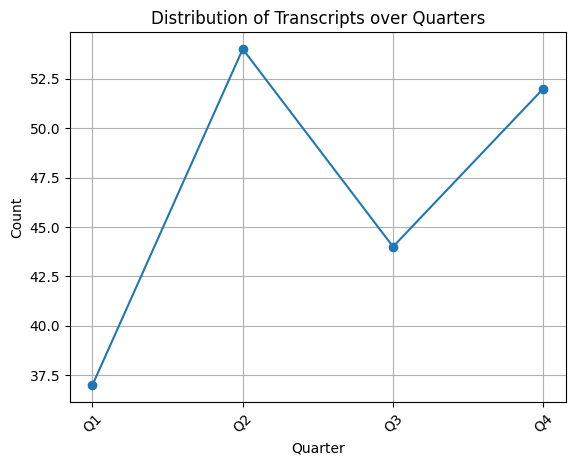

In [11]:
# Count the occurrences of each quarter
quarter_counts = df_clean['Quarter'].value_counts().sort_index()

# Create a line chart
plt.plot(quarter_counts.index, quarter_counts.values, marker='o')
plt.xlabel('Quarter')
plt.ylabel('Count')
plt.title('Distribution of Transcripts over Quarters')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

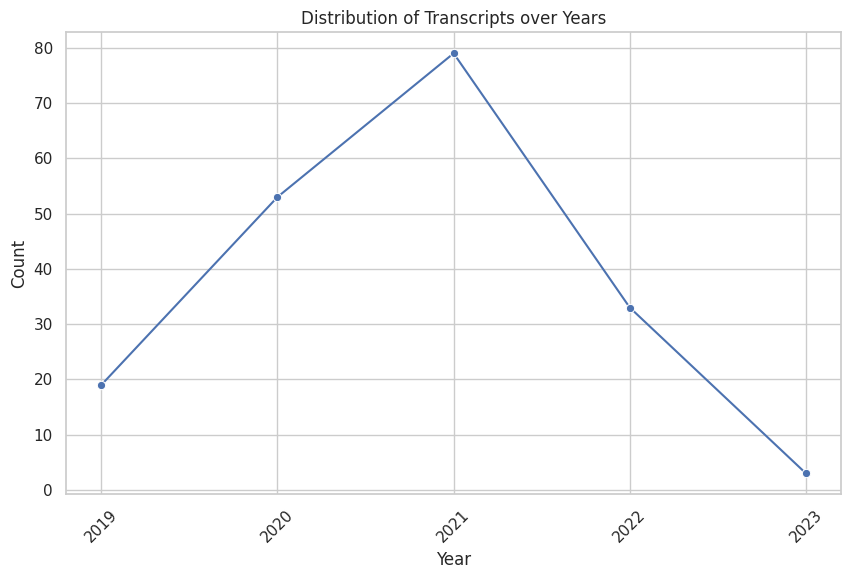

In [12]:
# Count the occurrences of each year
year_counts = df_clean['Year'].value_counts().sort_index()

# Create a line chart using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=year_counts.index, y=year_counts.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Distribution of Transcripts over Years')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [13]:
df_clean['new_texts'] = None

for i, row in df_clean.iterrows():

  year = row['Year']
  quarter = row['Quarter']
  text = row['transcript_y']

  new_text = [f"Year: {year}", f"Quarter: {quarter}", f"transcript: {text}"]

  df_clean.at[i, 'new_texts'] = new_text

/tmp/ipykernel_11780/3594869880.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['new_texts'] = None


In [14]:
# Add new column
df_clean['label'] = ''

# Condition to check if value is above 0.6
cond = df_clean['Positive'] > 0.6

# Assign labels to new column
df_clean['label'] = np.where(cond, '1', '0')
df_clean['label_N'] = np.where(cond, 'increase', 'decrease')

/tmp/ipykernel_11780/2579129284.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['label'] = ''
/tmp/ipykernel_11780/2579129284.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['label'] = np.where(cond, '1', '0')
/tmp/ipykernel_11780/2579129284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [15]:
label_counts = pd.DataFrame(df_clean['label_N'].value_counts())
label_counts

,count
label_N,
increase,97
decrease,90


In [16]:
label_values = list(label_counts.index)
order = list(pd.DataFrame(df_clean['label_N'].value_counts()).index)
label_values = [l for _,l in sorted(zip(order, label_values))]

label_values

['decrease', 'increase']

In [17]:
pattern = r"[\[\]]"

df_clean['new_texts'] = df_clean['new_texts'].apply(lambda x: re.sub(pattern, '', str(x)))
df_clean['new_texts']

/tmp/ipykernel_11780/1269960740.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['new_texts'] = df_clean['new_texts'].apply(lambda x: re.sub(pattern, '', str(x)))


0      'Year: 2021', 'Quarter: Q2', "transcript: Prep...
1      'Year: 2021', 'Quarter: Q1', "transcript: Prep...
2      'Year: 2022', 'Quarter: Q2', "transcript: Prep...
3      'Year: 2020', 'Quarter: Q4', "transcript: Prep...
4      'Year: 2020', 'Quarter: Q3', "transcript: Prep...
                             ...                        
183    'Year: 2021', 'Quarter: Q3', "transcript: Prep...
184    'Year: 2021', 'Quarter: Q2', "transcript: Prep...
185    'Year: 2021', 'Quarter: Q4', "transcript: Prep...
186    'Year: 2020', 'Quarter: Q4', "transcript: Prep...
187    'Year: 2021', 'Quarter: Q2', "transcript: Prep...
Name: new_texts, Length: 187, dtype: object

In [18]:
texts= df_clean['new_texts'].values
labels= df_clean['label'].values

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

print('Original Text: ', texts[0], '\n')
print('Tokenized Text: ', tokenizer.tokenize(texts[0]), '\n')
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(texts[0])))

Original Text:  'Year: 2021', 'Quarter: Q2', "transcript: Prepared Remarks:\nOperator\nGood day and thank you for standing by. Welcome to the RenaissanceRe Insurance Second Quarter Earnings Conference Call. Operator Instructions Please be advised that today's conference is being recorded. Operator Instructions\nI would now like to hand the conference over to one of your speakers today, Keith McCue, SVP, Finance and Investor Relations. Please go ahead.\nKeith McCue -- Senior Vice President, Finance and Investor Relations\nThank you. Good morning. Thank you for joining our first Phonetic quarter financial results conference call.\nYesterday, after the market close, we issued our quarterly release. If you didn't receive a copy, please call me at 441-239-4830 and we'll make sure to provide you with one. There will be an audio replay of the call available from about 1:30 PM Eastern Time today through midnight on August 23. The replay can be accessed by dialing 855-859-2056 US toll free or 1

In [19]:
text_ids = [tokenizer.encode(text, max_length=512, pad_to_max_length=True) for text in texts]

text_ids[0]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/shane/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


[101,
 1005,
 2095,
 1024,
 25682,
 1005,
 1010,
 1005,
 4284,
 1024,
 1053,
 2475,
 1005,
 1010,
 1000,
 24051,
 1024,
 4810,
 12629,
 1024,
 1032,
 16780,
 16259,
 1032,
 17895,
 7716,
 2154,
 1998,
 4067,
 2017,
 2005,
 3061,
 2011,
 1012,
 6160,
 2000,
 1996,
 8028,
 2890,
 5427,
 2117,
 4284,
 16565,
 3034,
 2655,
 1012,
 6872,
 8128,
 3531,
 2022,
 9449,
 2008,
 2651,
 1005,
 1055,
 3034,
 2003,
 2108,
 2680,
 1012,
 6872,
 8128,
 1032,
 9152,
 2052,
 2085,
 2066,
 2000,
 2192,
 1996,
 3034,
 2058,
 2000,
 2028,
 1997,
 2115,
 7492,
 2651,
 1010,
 6766,
 23680,
 5657,
 1010,
 17917,
 2361,
 1010,
 5446,
 1998,
 14316,
 4262,
 1012,
 3531,
 2175,
 3805,
 1012,
 1032,
 25930,
 20175,
 2232,
 23680,
 5657,
 1011,
 1011,
 3026,
 3580,
 2343,
 1010,
 5446,
 1998,
 14316,
 4262,
 1032,
 23961,
 4819,
 2243,
 2017,
 1012,
 2204,
 2851,
 1012,
 4067,
 2017,
 2005,
 5241,
 2256,
 2034,
 26664,
 4284,
 3361,
 3463,
 3034,
 2655,
 1012,
 1032,
 6396,
 20367,
 10259,
 1010,
 2044,
 1996,
 30

### Tokenize and Encode whole dataset. 
    * Encode using corresponding numerical values for each token
    * Tokenize text like previous step
    * Max length is 300
    * Include special tokens such as the start and end 

In [20]:
text_ids_lengths = [len(text_ids[i]) for i in range(len(text_ids))]
print(min(text_ids_lengths))
print(max(text_ids_lengths))

512
512


### Fine tune the model. Separate into two arrays: one array of token IDs like above, another array of a corresponding binary mask (attention mask in BERT). Each attention mask has the same length of the corresponding input sequence and has a 0 if the corresponding token is for padding or 1.

In [21]:
att_masks = []
for ids in text_ids:
    masks = [int(id > 0) for id in ids]
    att_masks.append(masks)

att_masks[0]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


## NN: Now it's the fun part. I'm splitting the input and output arrays into train, validation, and test sets: 80% training, 10% validation, 10% testing

In [22]:
train_x, test_val_x, train_y, test_val_y = train_test_split(text_ids, labels, random_state=111, test_size=0.2)
train_m, test_val_m = train_test_split(att_masks, random_state=111, test_size=0.2)

test_x, val_x, test_y, val_y = train_test_split(test_val_x, test_val_y, random_state=111, test_size=0.5)
test_m, val_m = train_test_split(test_val_m, random_state=111, test_size=0.5)

In [23]:
train_y = train_y.astype(int) # if strings, convert to int
test_y = test_y.astype(int) # if strings, convert to int
val_y  = val_y .astype(int) # if strings, convert to int

In [24]:
train_x = torch.tensor(train_x)
test_x = torch.tensor(test_x)
val_x = torch.tensor(val_x)
train_y = torch.tensor(train_y)
test_y = torch.tensor(test_y)
val_y = torch.tensor(val_y)
train_m = torch.tensor(train_m)
test_m = torch.tensor(test_m)
val_m = torch.tensor(val_m)

print(train_x.shape)
print(test_x.shape)
print(val_x.shape)
print(train_y.shape)
print(test_y.shape)
print(val_y.shape)
print(train_m.shape)
print(test_m.shape)
print(val_m.shape)

torch.Size([149, 512])
torch.Size([19, 512])
torch.Size([19, 512])
torch.Size([149])
torch.Size([19])
torch.Size([19])
torch.Size([149, 512])
torch.Size([19, 512])
torch.Size([19, 512])


### Our results will be tensors, hence above. In addition, I am using pytorch's Dataset, DataLoader, and Sampler. For the training set, I will use RandomSampler. For validation set, will use SequentialSampler.

In [25]:
batch_size = 32

train_data = TensorDataset(train_x, train_m, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_x, val_m, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [26]:
num_labels = len(set(labels))

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels,
                                                            output_attentions=False, output_hidden_states=False)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = model.to(device)

cuda


#### God, I love GPU backend!

In [29]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Number of trainable parameters:', count_parameters(model), '\n', model)

Number of trainable parameters: 66955010 
 DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
           

In [30]:
[n for n, p in model.named_parameters()]

['distilbert.embeddings.word_embeddings.weight',
 'distilbert.embeddings.position_embeddings.weight',
 'distilbert.embeddings.LayerNorm.weight',
 'distilbert.embeddings.LayerNorm.bias',
 'distilbert.transformer.layer.0.attention.q_lin.weight',
 'distilbert.transformer.layer.0.attention.q_lin.bias',
 'distilbert.transformer.layer.0.attention.k_lin.weight',
 'distilbert.transformer.layer.0.attention.k_lin.bias',
 'distilbert.transformer.layer.0.attention.v_lin.weight',
 'distilbert.transformer.layer.0.attention.v_lin.bias',
 'distilbert.transformer.layer.0.attention.out_lin.weight',
 'distilbert.transformer.layer.0.attention.out_lin.bias',
 'distilbert.transformer.layer.0.sa_layer_norm.weight',
 'distilbert.transformer.layer.0.sa_layer_norm.bias',
 'distilbert.transformer.layer.0.ffn.lin1.weight',
 'distilbert.transformer.layer.0.ffn.lin1.bias',
 'distilbert.transformer.layer.0.ffn.lin2.weight',
 'distilbert.transformer.layer.0.ffn.lin2.bias',
 'distilbert.transformer.layer.0.output_laye

### Now for the NN. I will be using Adam as the optimizer like usual. 

In [31]:
learning_rate = 1e-5
adam_epsilon = 1e-8

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.2},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

/home/shane/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [32]:
num_epochs = 100
total_steps = len(train_dataloader) * num_epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [33]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [34]:
seed_val = 111

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [35]:
print(next(model.parameters()).device)

cuda:0


In [36]:
device = torch.device('cuda')
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [37]:
print(torch.cuda.is_available())

True


### Here we go!

In [38]:
train_losses = []
val_losses = []
num_mb_train = len(train_dataloader)
num_mb_val = len(val_dataloader)

if num_mb_val == 0:
    num_mb_val = 1

for n in range(num_epochs):
    train_loss = 0
    val_loss = 0
    start_time = time.time()

    for k, (mb_x, mb_m, mb_y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        model.train()

        mb_x = mb_x.to(device)
        mb_m = mb_m.to(device)
        mb_y = mb_y.to(device)

        outputs = model(mb_x, attention_mask=mb_m, labels=mb_y)

        loss = outputs[0]
        #loss = model_loss(outputs[1], mb_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        train_loss += loss.data / num_mb_train

    print ("\nTrain loss after itaration %i: %f" % (n+1, train_loss))
    train_losses.append(train_loss.cpu())

    with torch.no_grad():
        model.eval()

        for k, (mb_x, mb_m, mb_y) in enumerate(val_dataloader):
            mb_x = mb_x.to(device)
            mb_m = mb_m.to(device)
            mb_y = mb_y.to(device)

            outputs = model(mb_x, attention_mask=mb_m, labels=mb_y)

            loss = outputs[0]
            #loss = model_loss(outputs[1], mb_y)

            val_loss += loss.data / num_mb_val

        print ("Validation loss after itaration %i: %f" % (n+1, val_loss))
        val_losses.append(val_loss.cpu())

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Time: {epoch_mins}m {epoch_secs}s')


Train loss after itaration 1: 0.694557
Validation loss after itaration 1: 0.739342
Time: 0m 4s

Train loss after itaration 2: 0.693899
Validation loss after itaration 2: 0.707768
Time: 0m 1s

Train loss after itaration 3: 0.690314
Validation loss after itaration 3: 0.695554
Time: 0m 1s

Train loss after itaration 4: 0.686891
Validation loss after itaration 4: 0.701893
Time: 0m 1s

Train loss after itaration 5: 0.681242
Validation loss after itaration 5: 0.695929
Time: 0m 1s

Train loss after itaration 6: 0.676062
Validation loss after itaration 6: 0.698767
Time: 0m 1s

Train loss after itaration 7: 0.673623
Validation loss after itaration 7: 0.685466
Time: 0m 1s

Train loss after itaration 8: 0.662895
Validation loss after itaration 8: 0.670282
Time: 0m 1s

Train loss after itaration 9: 0.641528
Validation loss after itaration 9: 0.673283
Time: 0m 1s

Train loss after itaration 10: 0.617416
Validation loss after itaration 10: 0.700457
Time: 0m 1s

Train loss after itaration 11: 0.5857

### GPU usage went up to 100% from the above. Crazy. I'm going to try to turn this as a class or function for modularity. Namely because I dont want some minor mistake all the way in the beginning making me have to run every single thing again. 

In [39]:
out_dir = './model'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(out_dir)
tokenizer.save_pretrained(out_dir)

with open(out_dir + '/train_losses.pkl', 'wb') as f:
    pickle.dump(train_losses, f)

with open(out_dir + '/val_losses.pkl', 'wb') as f:
    pickle.dump(val_losses, f)

In [40]:
out_dir = './model'

model = DistilBertForSequenceClassification.from_pretrained(out_dir)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

with open(out_dir + '/train_losses.pkl', 'rb') as f:
    train_losses = pickle.load(f)

with open(out_dir + '/val_losses.pkl', 'rb') as f:
    val_losses = pickle.load(f)

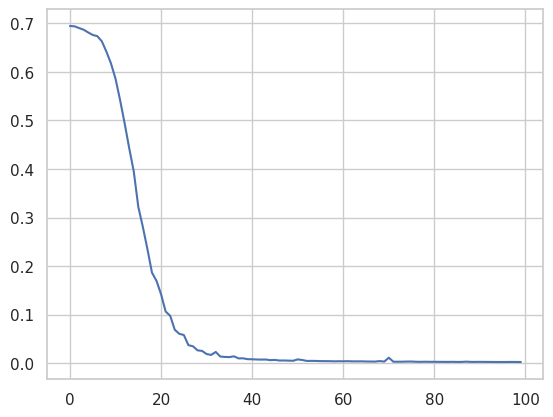

In [41]:
plt.figure()
plt.plot(train_losses)

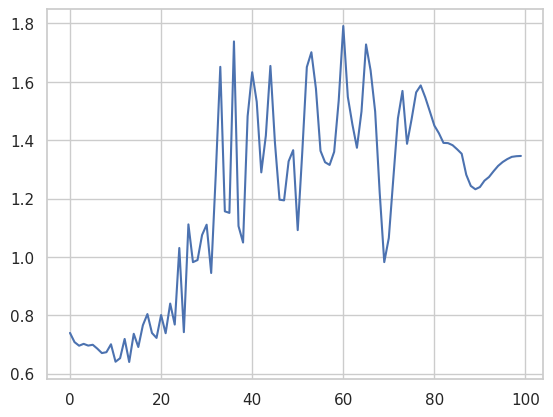

In [42]:
plt.figure()
plt.plot(val_losses)

### Not too pleased with these results so will have to fix this at some point. Now, I'm just going to run the test set and validation set.

In [43]:
batch_size = 32

test_data = TensorDataset(test_x, test_m)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

outputs = []
with torch.no_grad():
    model.eval()
    for k, (mb_x, mb_m) in enumerate(test_dataloader):
        mb_x = mb_x.to(device)
        mb_m = mb_m.to(device)
        output = model(mb_x, attention_mask=mb_m)
        outputs.append(output[0].to('cpu'))

outputs = torch.cat(outputs)

In [44]:
_, predicted_values = torch.max(outputs, 1)
predicted_values = predicted_values.numpy()
true_values = test_y.numpy()

In [45]:
test_accuracy = np.sum(predicted_values == true_values) / len(true_values)
print ("Test Accuracy:", test_accuracy)

Test Accuracy: 0.5789473684210527


In [46]:
print(classification_report(true_values, predicted_values, target_names=[str(l) for l in label_values]))

              precision    recall  f1-score   support

    decrease       0.33      0.33      0.33         6
    increase       0.69      0.69      0.69        13

    accuracy                           0.58        19
   macro avg       0.51      0.51      0.51        19
weighted avg       0.58      0.58      0.58        19



In [47]:
# plot confusion matrix
# code borrowed from scikit-learn.org
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[2 4]
 [4 9]]
Normalized confusion matrix
[[0.3 0.7]
 [0.3 0.7]]


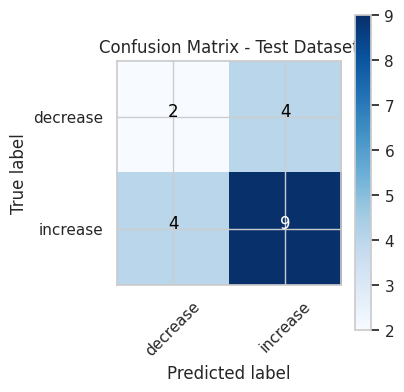

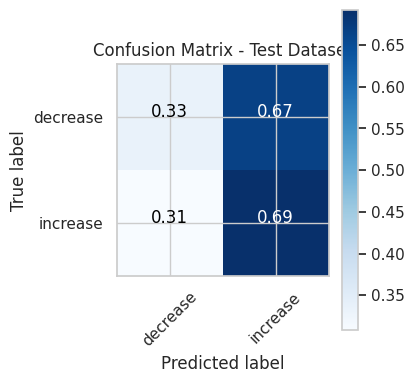

In [48]:
cm_test = confusion_matrix(true_values, predicted_values)

np.set_printoptions(precision=1)

plt.figure(figsize=(4,4))
plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset')
plt.figure(figsize=(4,4))
plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset', normalize=True)